In [ ]:
!git clone --depth 1 https://github.com/phil329/SDFlow.git
!pip install -r SDFlow/requirements.txt

In [ ]:
! nvidia-smi # make sure that GPU is used

# You have to change the runtime type to GPU, then restart the runtime.
# Menu: Runtime -> Change runtime type -> Hardware accelerator -> GPU

In [ ]:
import gdown
gdown.download_folder('https://drive.google.com/drive/u/0/folders/1bOObaXE-zY_7-pXNyuTnhKvkn1wCqkaT')
!mv data/* SDFlow/data
!rm -rf data

In [1]:
import os
os.chdir('/content/SDFlow') # change to the root directory of the project in Google Colab

# os.chdir('/home/blli/SDFlow')
# os.environ["CUDA_VISIBLE_DEVICES"] = "3"

import sys

import cv2
import random
import numpy as np
import pickle
import copy
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
import torchvision
from torch.utils.data import DataLoader
import torch.distributions as D
from torchvision.transforms.functional import to_pil_image
from torchvision.utils import make_grid
from tqdm import tqdm, trange
from common.loggerx import LoggerXBase

from models.flows.flow import cnf
from common.ops import load_network

from models.stylegan2 import Generator
from models.attribute_estimator import AttributeClassifier
torch.autograd.set_grad_enabled(False)

/home/blli/anaconda3/envs/seflow/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# gloabl settings
class config(object):
    latent_file='./data/ffhq_e4e_latents.pth'
    index_file='./data/ffhq.txt'
    image_root='/mnt/local1_ssd/blli/dataset/FFHQ/images256x256'
    
    stygan2_weights='./data/stylegan2-ffhq-config-f.pt'
    e4e_weights='./data/e4e_ffhq_encode.pt'
    
    all_attributes_list = ['5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes', 'Bald',
                           'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair',
                           'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup',
                           'High_Cheekbones', 'Male', 'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard',
                           'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns',
                           'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick',
                           'Wearing_Necklace', 'Wearing_Necktie', 'Young'
                           ]
    
    attribute_index=[15,20,39]
    attribute_weights='./data/r34_a40_age_256_classifier.pth'
    flow_modules='512-512-512-512-512'
    batch=8
    num_workers=16
    img_size=256
    
    device = "cuda" if torch.cuda.is_available() else 'cpu'

args = config()

In [3]:
# model initialization for :
# 1. e4e encoder
# 2. stylegan2 generator
# 3. attribute classifier

from models.e4e import Encoder4Editing

e4e_encoder = Encoder4Editing(num_layers=50, mode='ir_se', stylegan_size=1024, checkpoint_path=args.e4e_weights).eval().to(args.device)

print('** e4e encoder loads successfully!')

# use decoder image classifier
attributes_model = AttributeClassifier(backbone='r34')
attributes_model.load_state_dict(load_network(args.attribute_weights))
attributes_model = attributes_model.eval().to(args.device)
print('** Attribute classifier initialization success !')

# Initialization for stylegan2 model
ckpt = torch.load(args.stygan2_weights,map_location='cpu')

latent_avg = ckpt['latent_avg'].to(args.device)

G = Generator(size=1024,style_dim=512,n_mlp=8)
G.load_state_dict(ckpt['g_ema'])
G.eval().to(args.device)
print('** StyleGAN2 model initialization success !')

** e4e encoder loads successfully!
** Attribute classifier initialization success !
** StyleGAN2 model initialization success !


In [4]:
# A helper function to simplify the stylegan2's generation process
def decoder(latent,img_size=256):
    with torch.no_grad():
        img = G(
            [latent],
            input_is_latent=True,
            randomize_noise=False,
        )[0].clamp(min=-1, max=1)
    if img_size != 1024:
        img = F.interpolate(img, size=(img_size, img_size), mode='bilinear', align_corners=True)
    return img

In [5]:
# randomly sample a face image using stylegan2 generator
with torch.no_grad():
    ws = G.get_latent(torch.randn((1,512)).to(args.device))
    face_tensor = decoder(ws)

# to_pil_image(make_grid(face_tensor*0.5+0.5))

In [6]:
# Test for attribute classifier and e4e encoder
with torch.no_grad():
    latents = e4e_encoder(F.interpolate(face_tensor,(256,256)))
    latents += latent_avg
    sources = attributes_model(F.interpolate(face_tensor,(256,256)))[1]
    projected = decoder(latents)
    
# to_pil_image(make_grid(projected*0.5+0.5))


In [7]:
# define the SDFlow editor
from models.editor import SDFlow

transformer = SDFlow(ckpt_dir='./data/ckpt', attr_num=39,attr_list=args.attribute_index,scale=0.2,device=args.device)


sampled face 			 projected face 			 edited face


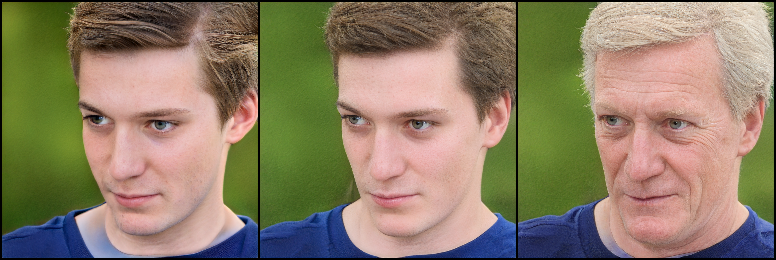

In [10]:
# edit the sampled face image and display the results
with torch.no_grad():
    new_latents = transformer.transform(latents, sources,F.interpolate(face_tensor,(256,256)))
    edit_img = decoder(new_latents)

merge = torch.concat([face_tensor,projected,edit_img],dim=0)

print('sampled face \t\t\t projected face \t\t\t edited face')
display(to_pil_image(make_grid(merge*0.5+0.5)))

# Test for Real-world Face attribute manipulation

(226, 400, 3)


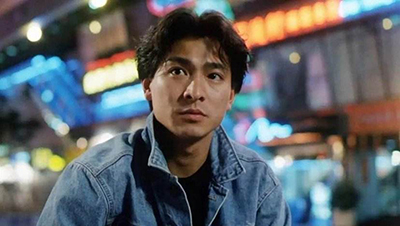

In [11]:
# There are some demo images in the data folder, you can also test the SDFlow editor on them
# for example: test1.jpg test2.jpg test3.jpg test4.jpg test5.jpg

image = cv2.imread(f'./face_images/test2.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

print(image.shape)
display(to_pil_image(image))

0
(256, 256, 3) <class 'numpy.ndarray'> 255


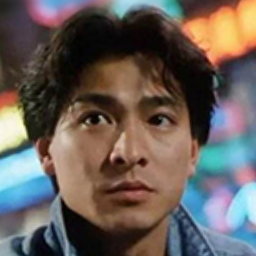

In [12]:
from models.face_align.dlib_face_align import face_alignment

# Face is aligned to Stylegan2 template and resized to 256x256
aligned_image, inv_M = face_alignment(image, output_size=256)
print(aligned_image.shape,type(aligned_image),aligned_image.max())

display(to_pil_image(aligned_image))

torch.Size([1, 18, 512]) torch.Size([1, 41])


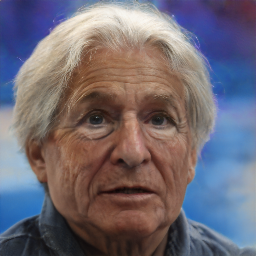

In [13]:

input_image = torch.from_numpy(aligned_image).permute((2, 0, 1)).to(args.device).unsqueeze(0).float()
input_image = (input_image / 255. - 0.5) * 2

# Obtain the latent code and attribute code of the input image
source = attributes_model(input_image)[1]
latent = e4e_encoder(input_image)
latent += latent_avg

print(latent.shape,source.shape)

# edit the input latent code 
new_latent = transformer.transform(latent, source,input_image)

edit_image = decoder(new_latent)

display(to_pil_image(make_grid(edit_image*0.5+0.5)))

In [14]:
# Display the edited results of different scales
# Here we set the scale range to [-0.6,0.5] with a step size of 0.3
# An ideal scale range is [-1,1]

scale_list = np.arange(-0.6,0.5,0.3)

edit_list = []

for scale in scale_list:
    transformer = SDFlow(ckpt_dir='./data/ckpt', attr_num=39,scale=scale,device='cuda')
    new_latent = transformer.transform(latent, source,input_image)
    edit_image = decoder(new_latent)
    edit_list.append(edit_image)

torch.Size([4, 3, 256, 256])


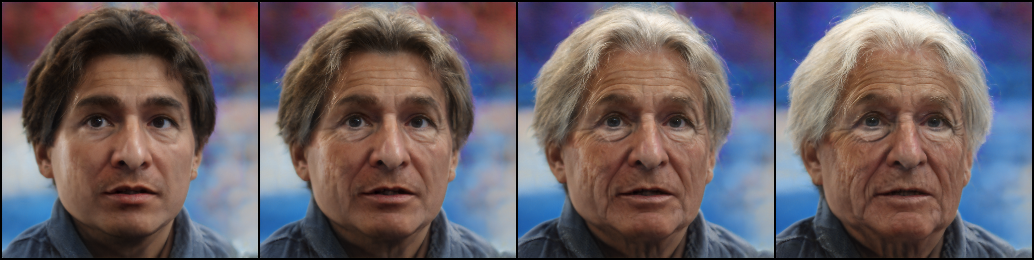

In [15]:
edit_image_scale = torch.concat(edit_list,dim=0)
print(edit_image_scale.shape)

display(to_pil_image(make_grid(edit_image_scale*0.5+0.5,nrow=len(edit_list))))